In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from utils import convert_less_than, plot_distribution

In [52]:
COLUMNS = ["Carbon concentration / (weight%)", 
           "Silicon concentration / (weight%)", 
           "Manganese concentration / (weight%)", 
           "Sulphur concentration / (weight%)", 
           "Phosphorus concentration / (weight%)", 
           "Nickel concentration / (weight%)", 
           "Chromium concentration / (weight%)", 
           "Molybdenum concentration / (weight%)", 
           "Vanadium concentration / (weight%)", 
           "Copper concentration / (weight%)", 
           "Cobalt concentration / (weight%)", 
           "Tungsten concentration / (weight%)", 
           "Oxygen concentration / parts per million by weight", 
           "Titanium concentration / parts per million by weight", 
           "Nitrogen concentration / parts per million by weight", 
           "Aluminium concentration / parts per million by weight", 
           "Boron concentration / parts per million by weight", 
           "Niobium concentration / parts per million by weight", 
           "Tin concentration / parts per million by weight", 
           "Arsenic concentration / parts per million by weight", 
           "Antimony concentration / parts per million by weight", 
           "Current / A", 
           "Voltage / V", 
           "AC or DC", 
           "Electrode positive or negative", 
           "Heat input / kJmm-1", 
           "Interpass temperature / °C", 
           "Type of weld", 
           "Post weld heat treatment temperature / °C", 
           "Post weld heat treatment time / hours", 
           "Yield strength / MPa", 
           "Ultimate tensile strength / MPa", 
           "Elongation / %", 
           "Reduction of Area / %", 
           "Charpy temperature / °C", 
           "Charpy impact toughness / J", 
           "Hardness / kgmm-2", 
           "50% FATT", 
           "Primary ferrite in microstructure / %", 
           "Ferrite with second phase / %", 
           "Acicular ferrite / %", 
           "Martensite / %", 
           "Ferrite with carbide aggreagate / %",
            "Weld ID"
            ]
CATEGORICAL_COL = [
    "AC or DC", 
    "Electrode positive or negative", 
    "Type of weld", 
    "Weld ID"
]
MECHANICAL_PROPERTIES = [
    "Yield strength / MPa",
    "Ultimate tensile strength / MPa",
    "Elongation / %",
    "Reduction of Area / %",
    "Charpy temperature / °C",
    "Charpy impact toughness / J",
    "Hardness / kgmm-2",
    "50% FATT",
    "Primary ferrite in microstructure / %",
    "Ferrite with second phase / %",
    "Acicular ferrite / %",
    "Martensite / %",
    "Ferrite with carbide aggreagate / %"
]
NUMERICAL_COL = list(set(COLUMNS) - set(CATEGORICAL_COL))

In [53]:
def create_database(file_path):

    db = pd.read_csv(file_path, delimiter = "\s+", names=COLUMNS, na_values='N').drop('Weld ID', axis=1)
    db[NUMERICAL_COL] = db[NUMERICAL_COL].map(convert_less_than)
    db[NUMERICAL_COL] = db[NUMERICAL_COL].apply(pd.to_numeric, errors='coerce')

    db.to_csv("table.csv")
    return db

In [69]:
file_path="welddb/welddb.data"
db = create_database(file_path)

### - Handling categorical features
- Handling **'Type of weld'** feature

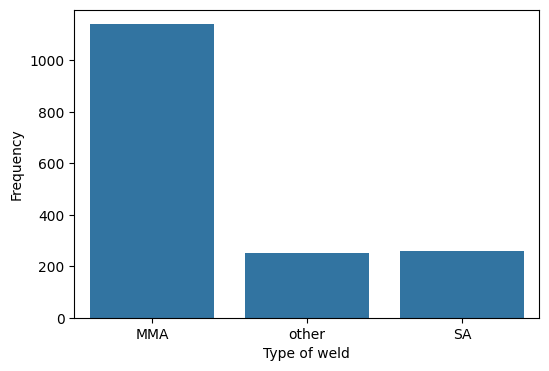

In [70]:
types_of_weld = ['MMA', 'SA', 'other']

db.loc[:, 'Type of weld'] = db['Type of weld'].apply(lambda x: x if x in types_of_weld else 'other')
plot_distribution(db['Type of weld'])

db = pd.get_dummies(db, columns=['Type of weld'], prefix='weld', dtype=int,).drop(columns=['weld_other'])

CATEGORICAL_COL.extend(['weld_MMA', 'weld_SA'])

- Handling **'AC or DC'** feature

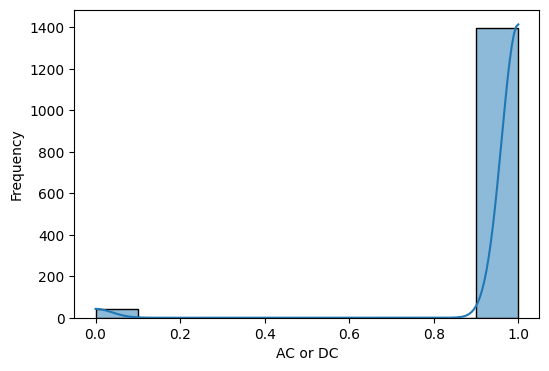

In [71]:
for i in range(len(db)):
    if db.iloc[i]["AC or DC"] is None and db.iloc[i]['Electrode positive or negative'] is not None:  # Correct None check
        if db.iloc[i]['Electrode positive or negative'] == 0:
            db.iloc[i]["AC or DC"] = "AC"
        else: 
            db.iloc[i]["AC or DC"] = "DC"
            
#This did not do anything

mapping_dict = {'AC': 0, 'DC': 1}
db['AC or DC'] = db['AC or DC'].map(mapping_dict)

plot_distribution(db['AC or DC'])

- Handling **'Electrode positive or negative'** feature

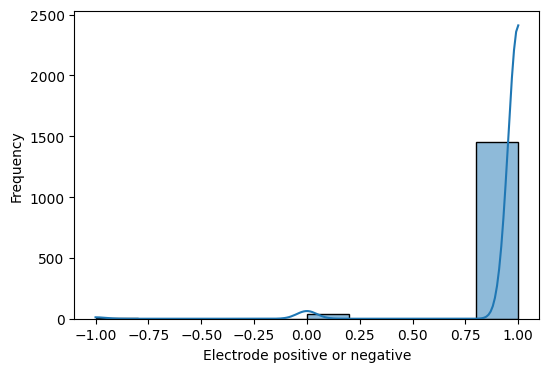

In [72]:
mapping_dict = {'+': 1, '0': 0, '-': -1}
db['Electrode positive or negative'] = db['Electrode positive or negative'].map(mapping_dict)
plot_distribution(db['Electrode positive or negative'])

### - Selecting relavant features based on Correlation and Completeness
#### TARGET = Yield strength / MPa

In [73]:
def get_corr(table:pd.DataFrame, threshold):
    # Initialize the result dictionary
    col_info = {
        'below_threshold': [],  # Columns with too many missing values
        'above_threshold': [],  # Columns passing the threshold
        'columns': {}           # Store correlation and missing percentage
    }
    
    for col in table.columns:
        column = table[col]
        missing_ratio = column.isnull().mean()
        
        col_info['columns'][col] = {'missing_ratio': missing_ratio}
        if missing_ratio > 1 - threshold:
            col_info['below_threshold'].append(col)
        else:
            col_info['above_threshold'].append(col)
        
        valid_rows = table[[col, 'Yield strength / MPa']].dropna()
        
        if not valid_rows.empty and col not in CATEGORICAL_COL:
            correlation = valid_rows.corr()
            col_info['columns'][col]['correlation_with_output'] = correlation.values[0,1]
        else:
            col_info['columns'][col]['correlation_with_output'] = np.nan  # No valid data to correlate

    return col_info

In [74]:
threshold = 0.3
col_info = get_corr(db, threshold)
# col_info

In [75]:
points = np.array([(0, 0.45), (0.6, 0.05)])
x_points = points[:, 0]
y_points = points[:, 1]
coefficients = np.polyfit(x_points, y_points, 2)
feature_decision = np.vectorize(lambda completeness: max(0.05, np.polyval(coefficients, completeness)))


def plot_completeness_vs_corr(col_info, feature_decision=feature_decision):
    # Initialize lists to store x (completeness) and y (correlation) values
    x_completeness = []
    y_correlation = []
    column_names = []

    if feature_decision is None:
        features = col_info
    else:
        features=[]

    # Loop through the columns in col_info
    for col, info in col_info['columns'].items():
        if 'correlation_with_output' in info:  # Only consider columns with calculated correlation
            if col=='output':
                continue

            completeness = 1 - info['missing_ratio'] 
            correlation = abs(info['correlation_with_output'])
            
            x_completeness.append(completeness)
            y_correlation.append(correlation)
            column_names.append(col)
            if feature_decision is not None and feature_decision(completeness) >= correlation:
                features.append(col)
    
    # Plotting
    plt.figure(figsize=(20, 20))
    plt.scatter(x_completeness, y_correlation, color='b', marker='o')
    plt.ylim(0, 0.5)
    
    # Label each point with the column name
    for i, txt in enumerate(column_names):
        plt.annotate(txt, (x_completeness[i], y_correlation[i]), fontsize=9, ha='right')

    if feature_decision is not None:
        comp = np.linspace(min(x_completeness), max(x_completeness), 100)
        corr = feature_decision(comp)
        plt.plot(comp, corr, '-r')

    # Labels and title (in French)
    plt.xlabel("Complétude de la colonne (%)", fontsize=12)
    plt.ylabel("Corrélation avec 'output' en valeur absolue", fontsize=12)
    plt.title("Complétude vs Corrélation avec 'output'= Yield strength / MPa", fontsize=14)

    # Show grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

    return features

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18824\541153506.py:4: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_points, y_points, 2)


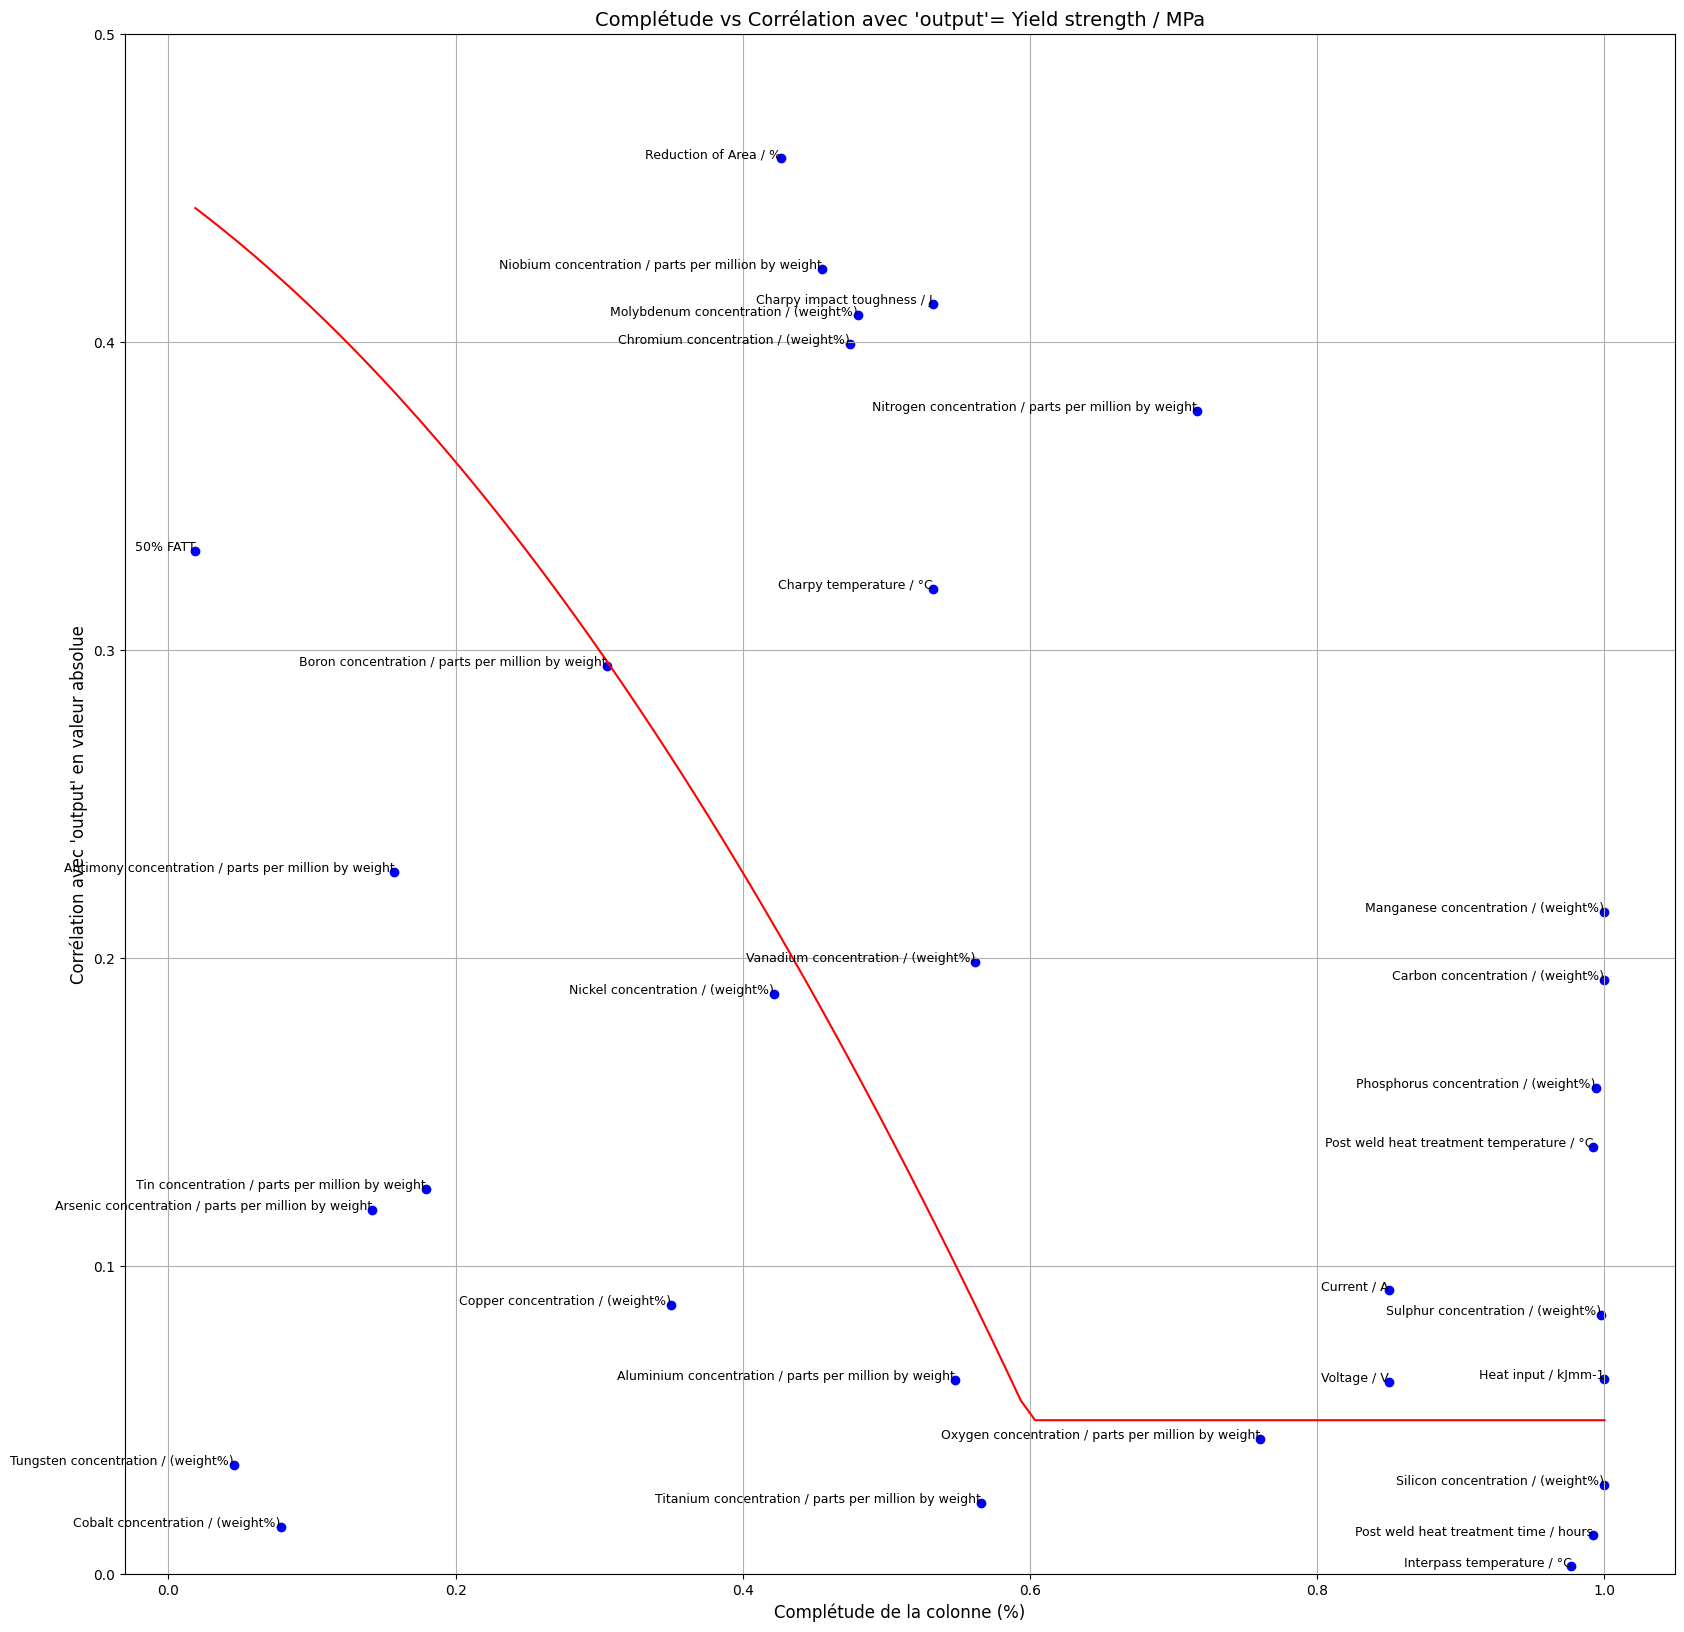

In [76]:
irrelevant_features = plot_completeness_vs_corr(col_info)

In [77]:
relevant_features = list(set(db.columns) - set(irrelevant_features))
df = db[relevant_features]

In [78]:
df.isna().mean()

Molybdenum concentration / (weight%)                    0.519976
Ferrite with carbide aggreagate / %                     0.946126
Electrode positive or negative                          0.094431
AC or DC                                                0.130145
Heat input / kJmm-1                                     0.000000
Phosphorus concentration / (weight%)                    0.006053
Elongation / %                                          0.576271
Charpy impact toughness / J                             0.467918
Acicular ferrite / %                                    0.945521
Current / A                                             0.150121
Primary ferrite in microstructure / %                   0.940678
Niobium concentration / parts per million by weight     0.544794
Ultimate tensile strength / MPa                         0.553269
Ferrite with second phase / %                           0.945521
Martensite / %                                          0.946126
Chromium concentration / 

### - Imputing numerical values

In [79]:
df1 = df.copy()

num_relev_cols = list(set(df1.columns) - set(CATEGORICAL_COL))

cols_to_impute = num_relev_cols
cols_to_impute

['Molybdenum concentration / (weight%)',
 'Nitrogen concentration / parts per million by weight',
 'Ferrite with carbide aggreagate / %',
 'Post weld heat treatment temperature / °C',
 'Heat input / kJmm-1',
 'Charpy temperature / °C',
 'Vanadium concentration / (weight%)',
 'Phosphorus concentration / (weight%)',
 'Elongation / %',
 'Charpy impact toughness / J',
 'Acicular ferrite / %',
 'Reduction of Area / %',
 'Current / A',
 'Primary ferrite in microstructure / %',
 'Niobium concentration / parts per million by weight',
 'Ultimate tensile strength / MPa',
 'Ferrite with second phase / %',
 'Martensite / %',
 'Chromium concentration / (weight%)',
 'Hardness / kgmm-2',
 'Carbon concentration / (weight%)',
 'Manganese concentration / (weight%)',
 'Yield strength / MPa',
 'Sulphur concentration / (weight%)',
 'Voltage / V']

In [80]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

iterative_imputer = IterativeImputer(random_state=42, sample_posterior=True)

df1[cols_to_impute] = iterative_imputer.fit_transform(df1[cols_to_impute])
df1.isna().mean()

Molybdenum concentration / (weight%)                    0.000000
Ferrite with carbide aggreagate / %                     0.000000
Electrode positive or negative                          0.094431
AC or DC                                                0.130145
Heat input / kJmm-1                                     0.000000
Phosphorus concentration / (weight%)                    0.000000
Elongation / %                                          0.000000
Charpy impact toughness / J                             0.000000
Acicular ferrite / %                                    0.000000
Current / A                                             0.000000
Primary ferrite in microstructure / %                   0.000000
Niobium concentration / parts per million by weight     0.000000
Ultimate tensile strength / MPa                         0.000000
Ferrite with second phase / %                           0.000000
Martensite / %                                          0.000000
Chromium concentration / 

### - Imputing categorical values

### Extracting dataset where TARGET != None

In [39]:
db["Yield strength / MPa"].isna().mean()

np.float64(0.5278450363196125)

We extract rows with "Yield strength / MPa" not None to create our dataset.

In [40]:
df = db.dropna(subset=['Yield strength / MPa'])
df.shape

(780, 44)